# Audio Classification



Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

# First approach: extracting features from a pretrained AST and training a linear classifier

In [ ]:
import logging
import os

import numpy as np
import pandas as pd
import requests
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Uploading dataset

In [ ]:
DATADIR = 'ml_trains_data'

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O data.tar.gz "{download_url}"
!tar -xf data.tar.gz

## Datasets for feature extraction

In [ ]:
class RawDataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        print(data)
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
        self._classes = len(labels) if read_labels else 0
        self._ytids = []
        self._pathes = []
        self._labels = []
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        return (waveform, self._labels[index], self._ytids[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes

In [ ]:
raw_trainset = RawDataset('train', DATADIR)
raw_testset = RawDataset('eval', DATADIR, read_labels=False)
N_CLASSES = raw_trainset.classes()
assert N_CLASSES == 30

                     YTID                         label
0       4i1aizhCnfg_30000                         Music
1      G3y5z37XW8E_200000                         Water
2       1imx8d_Ec_4_40000    Child speech, kid speaking
3       FJoR8b-lTgY_30000                        Engine
4       BDH7Fx1APR8_40000                         Music
...                   ...                           ...
26208   9K4_3pXBx9o_30000                          Bird
26209   Gcro5iNZYzY_30000  Heavy engine (low frequency)
26210   JcWq9vZQ8Zg_70000                      Laughter
26211   jzXQRlLXBZw_40000                     Whistling
26212   -0lziBunVX0_30000                        Speech

[26213 rows x 2 columns]
                    YTID
0      _oDTEjyE75U_40000
1     5A-8VUzAC1M_180000
2      2sfvzpI4MPE_50000
3      M6w5HD8YIsY_60000
4      4IEpPBzMCN4_10000
...                  ...
2995   Wj87qPZQKKw_30000
2996   37xr3DyPbwc_10000
2997       m66t_j137lw_0
2998   9roCUZR-xzM_30000
2999   3R1FIrnVo14_30000

[

In [ ]:
from collections import Counter

count = Counter(raw_trainset._idx_to_label[l] for l in raw_trainset._labels)
count.most_common(30)

[('Speech', 1600),
 ('Music', 1528),
 ('Vehicle', 1108),
 ('Animal', 1042),
 ('Siren', 984),
 ('Bird', 932),
 ('Water', 899),
 ('Engine', 879),
 ('Tools', 874),
 ('Crowd', 873),
 ('Gunshot, gunfire', 854),
 ('Car passing by', 850),
 ('Heavy engine (low frequency)', 834),
 ('Inside, small room', 821),
 ('Printer', 815),
 ('Fireworks', 796),
 ('Female singing', 786),
 ('Inside, large room or hall', 780),
 ('Vacuum cleaner', 779),
 ('Whack, thwack', 776),
 ('Outside, urban or manmade', 775),
 ('Singing', 772),
 ('Silence', 767),
 ('Outside, rural or natural', 760),
 ('Whistling', 753),
 ('Snoring', 753),
 ('Mantra', 748),
 ('Sound effect', 741),
 ('Laughter', 671),
 ('Child speech, kid speaking', 663)]

In [ ]:
for idx in range(5):
    raw = raw_trainset[idx][0].squeeze(0).numpy()
    print(f"---idx {idx}---\nSHAPE: {raw.shape}\nMAX: {np.max(raw)}\nMIN: {np.min(raw)}\nMEAN: {np.mean(raw)}\n")

---idx 0---
SHAPE: (160000,)
MAX: 0.9999998807907104
MIN: -1.0
MEAN: 0.00018658571934793144

---idx 1---
SHAPE: (160000,)
MAX: 0.9380624294281006
MIN: -0.9576534032821655
MEAN: 8.965083907241933e-06

---idx 2---
SHAPE: (160000,)
MAX: 0.5654585361480713
MIN: -0.6338474750518799
MEAN: -0.00011184425238752738

---idx 3---
SHAPE: (160000,)
MAX: 0.13896191120147705
MIN: -0.1466224193572998
MEAN: -8.715322474017739e-05

---idx 4---
SHAPE: (160000,)
MAX: 0.7668044567108154
MIN: -0.7258671522140503
MEAN: -7.218308746814728e-05



## Audio Spectrogram Transformer for feature extraction

In [ ]:
from transformers import AutoProcessor, ASTModel

checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(checkpoint)
model = ASTModel.from_pretrained(checkpoint).to(device)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ASTModel(
  (embeddings): ASTEmbeddings(
    (patch_embeddings): ASTPatchEmbeddings(
      (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ASTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ASTLayer(
        (attention): ASTSdpaAttention(
          (attention): ASTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ASTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ASTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [ ]:
batch_size = 64

def pad_or_trim_waveform(waveform, target_length):
    if waveform.shape[1] > target_length:
        return waveform[:, :target_length]
    elif waveform.shape[1] < target_length:
        padding = target_length - waveform.shape[1]
        return torch.nn.functional.pad(waveform, (0, padding), mode="constant", value=0)
    return waveform


def collate_fn(batch):
    max_length = max(waveform.shape[1] for waveform, _, _ in batch)
    waveforms = []
    labels = []
    ids = []
    for waveform, label, ytid in batch:
        waveform = pad_or_trim_waveform(waveform, max_length)
        waveforms.append(waveform)
        labels.append(label)
        ids.append(ytid)
    waveforms = torch.stack(waveforms)  # (batch_size, 1, max_length)
    labels = torch.tensor(labels, dtype=torch.long)
    return waveforms, labels, ids


train_raw_dataloader = torch_data.DataLoader(raw_trainset, batch_size, shuffle=False, collate_fn=collate_fn)
test_raw_dataloader = torch_data.DataLoader(raw_testset, batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
def get_features(loader):
    features = []
    labels_list = []
    ids_list = []
    for waveforms, labels, ids in tqdm(loader):
        inputs = processor(
            waveforms.squeeze(1).numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :] # (batch_size, seq_len, emb_dim) -> (batch_size, emb_dim)

        for emb_idx in range(embeddings.size(0)):
            features.append(embeddings[emb_idx, :].cpu())
            labels_list.append(labels[emb_idx])
            ids_list.append(ids[emb_idx])

    return features, labels_list, ids_list

In [ ]:
train_features, train_labels, train_ids = get_features(train_raw_dataloader)
test_features, test_labels, test_ids = get_features(test_raw_dataloader)

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
torch.save({
    "features": train_features,
    "labels": train_labels,
    "ids": train_ids
    }, "train_features.pt")

torch.save({
    "features": test_features,
    "labels": test_labels,
    "ids": test_ids
    }, "test_features.pt")

In [ ]:
train_features[0].size()

torch.Size([768])

In [ ]:
train_data = torch.load("train_features.pt")
train_features = train_data["features"]
train_labels = train_data["labels"]
train_ids = train_data["ids"]

test_data = torch.load("test_features.pt")
test_features = test_data["features"]
test_labels = test_data["labels"]
test_ids = test_data["ids"]

<ipython-input-107-7fe584b565a2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("train_features.pt")
<ipython-input-107-7fe584b565a2>:6: FutureWarn

## Dataloaders for classifier

In [ ]:
class Dataset(torch_data.Dataset):
    def __init__(self, features, ytids=None, labels=None):
        super().__init__()
        self.features = features
        self.ytids = ytids
        self.labels = labels

    def __getitem__(self, index):
        if self.labels:
            return (self.features[index], self.labels[index])
        return (self.features[index], self.ytids[index])

    def __len__(self):
        return len(self.features)


from sklearn.model_selection import train_test_split



train_features, val_features, train_labels, val_labels = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42
)



train_dataset = Dataset(train_features, None, train_labels)
val_dataset = Dataset(val_features, None, val_labels)
test_dataset = Dataset(test_features, test_ids, None)

batch_size = 32
train_loader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch_data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch_data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## Training classifier

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score


class AudioClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, input):
        output = self.fc1(input)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output


def train_epoch(model, optimizer, criterion, loader):
    model.train()
    cum_loss = 0
    all_preds = []
    all_labels = []
    for feats, labels in loader:
        feats, labels = feats.to(device), labels.to(device)
        output = model(feats)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()

        preds = torch.argmax(output, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    bacc = balanced_accuracy_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    return cum_loss/len(loader), bacc, acc


def evaluate(model, criterion, loader):
    model.eval()
    cum_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for feats, labels in loader:
            feats, labels = feats.to(device), labels.to(device)
            output = model(feats)
            loss = criterion(output, labels)
            cum_loss += loss.item()

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    bacc = balanced_accuracy_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    return cum_loss/len(loader), bacc, acc

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


epochs = 20
learning_rate = 1e-4
input_dim = 768
output_dim = 30
hidden_dim = 256
dropout_rate = 0.7

classifier = AudioClassifier(input_dim, output_dim, hidden_dim, dropout_rate).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
train_loss_history = []
val_loss_history = []
train_baccuracy_history = []
val_baccuracy_history = []

for epoch in tqdm(range(epochs)):
    train_loss, train_baccuracy, _ = train_epoch(classifier, optimizer, criterion, train_loader)
    val_loss, val_baccuracy, val_acc = evaluate(classifier, criterion, val_loader)

    scheduler.step(val_loss)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_baccuracy_history.append(train_baccuracy)
    val_baccuracy_history.append(val_baccuracy)

    print(f"EPOCH {epoch+1} Train Loss:{train_loss:.4f} Val Loss: {val_loss:.4f} Train BAcc: {train_baccuracy:.4f} Val BAcc: {val_baccuracy:.4f} Val Acc: {val_acc:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 1 Train Loss:2.0840 Val Loss: 1.2656 Train BAcc: 0.4402 Val BAcc: 0.6264 Val Acc: 0.6330
EPOCH 2 Train Loss:1.4457 Val Loss: 1.1639 Train BAcc: 0.5808 Val BAcc: 0.6431 Val Acc: 0.6452
EPOCH 3 Train Loss:1.3433 Val Loss: 1.1255 Train BAcc: 0.6005 Val BAcc: 0.6488 Val Acc: 0.6513
EPOCH 4 Train Loss:1.2756 Val Loss: 1.1055 Train BAcc: 0.6137 Val BAcc: 0.6559 Val Acc: 0.6576
EPOCH 5 Train Loss:1.2261 Val Loss: 1.0916 Train BAcc: 0.6280 Val BAcc: 0.6455 Val Acc: 0.6512
EPOCH 6 Train Loss:1.2021 Val Loss: 1.0821 Train BAcc: 0.6316 Val BAcc: 0.6501 Val Acc: 0.6544
EPOCH 7 Train Loss:1.1850 Val Loss: 1.0786 Train BAcc: 0.6353 Val BAcc: 0.6517 Val Acc: 0.6546
EPOCH 8 Train Loss:1.1515 Val Loss: 1.0735 Train BAcc: 0.6437 Val BAcc: 0.6516 Val Acc: 0.6548
EPOCH 9 Train Loss:1.1327 Val Loss: 1.0701 Train BAcc: 0.6455 Val BAcc: 0.6573 Val Acc: 0.6607
EPOCH 10 Train Loss:1.1258 Val Loss: 1.0634 Train BAcc: 0.6497 Val BAcc: 0.6552 Val Acc: 0.6588
EPOCH 11 Train Loss:1.1084 Val Loss: 1.0633 Train

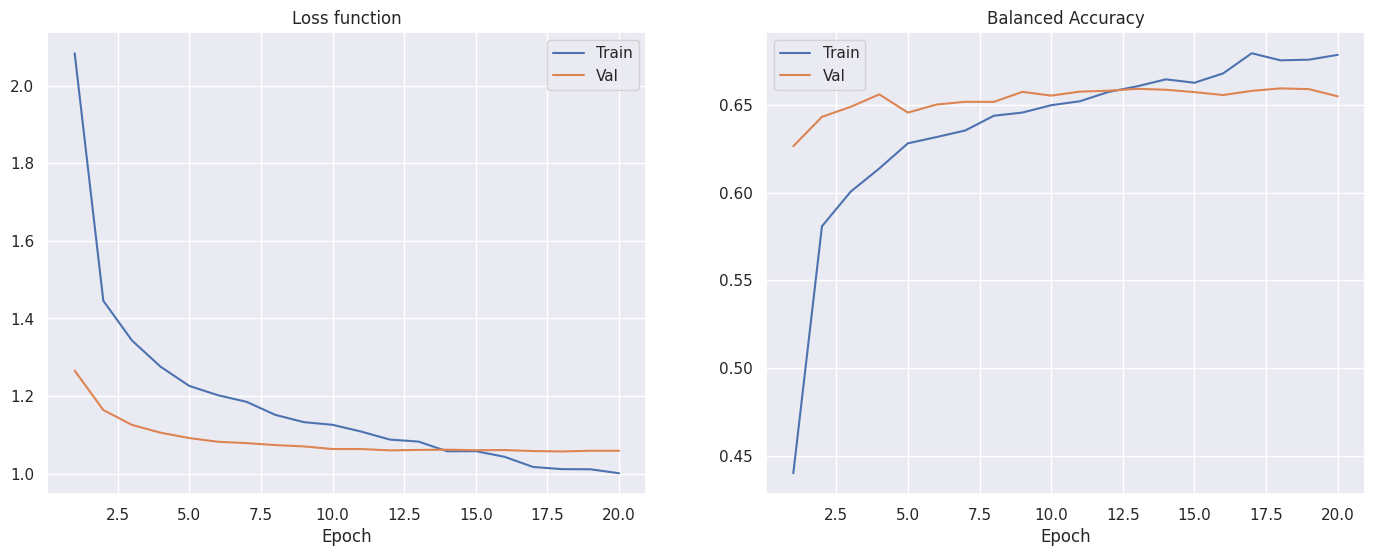

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline


fig, ax = plt.subplots(1, 2, figsize=(17, 6))
ax[0].set(title="Loss function", xlabel="Epoch",)
ax[0].plot(np.arange(1, len(train_loss_history)+1), train_loss_history, label="Train")
ax[0].plot(np.arange(1, len(val_loss_history)+1), val_loss_history, label="Val")
ax[0].legend()
ax[1].set(title="Balanced Accuracy", xlabel="Epoch")
ax[1].plot(np.arange(1, len(train_baccuracy_history)+1), train_baccuracy_history, label="Train")
ax[1].plot(np.arange(1, len(val_baccuracy_history)+1), val_baccuracy_history, label="Val")
ax[1].legend()
None

## Inference


In [ ]:
classifier.eval()
result = []
for features, id in test_loader:
    predict = torch.argmax(classifier.forward(features.to(device)), dim=1).item()
    result.append((id[0], raw_trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result3.tsv', sep='\t', index=False)

In [ ]:
classifier.eval()
predicted_labels = []
for batch in train_loader:
    features = batch[0]
    for i in range(features.size(0)):
        predict = torch.argmax(classifier.forward(features[i].unsqueeze(0).to(device)), dim=1).item()
        predicted_labels.append(raw_trainset._idx_to_label[predict])


for batch in val_loader:
    features = batch[0]
    for i in range(features.size(0)):
        predict = torch.argmax(classifier.forward(features[i].unsqueeze(0).to(device)), dim=1).item()
        predicted_labels.append(raw_trainset._idx_to_label[predict])

In [ ]:
count_predict = Counter(predicted_labels)
for l, c in count.most_common(30):
    print(f"{l}: {c} predicted: {count_predict.get(l)}")

Speech: 1600 predicted: 1588
Music: 1528 predicted: 1530
Vehicle: 1108 predicted: 1246
Animal: 1042 predicted: 1197
Siren: 984 predicted: 1048
Bird: 932 predicted: 935
Water: 899 predicted: 1001
Engine: 879 predicted: 826
Tools: 874 predicted: 945
Crowd: 873 predicted: 1016
Gunshot, gunfire: 854 predicted: 1048
Car passing by: 850 predicted: 1030
Heavy engine (low frequency): 834 predicted: 822
Inside, small room: 821 predicted: 800
Printer: 815 predicted: 870
Fireworks: 796 predicted: 808
Female singing: 786 predicted: 869
Inside, large room or hall: 780 predicted: 379
Vacuum cleaner: 779 predicted: 911
Whack, thwack: 776 predicted: 827
Outside, urban or manmade: 775 predicted: 327
Singing: 772 predicted: 717
Silence: 767 predicted: 720
Outside, rural or natural: 760 predicted: 560
Whistling: 753 predicted: 765
Snoring: 753 predicted: 757
Mantra: 748 predicted: 773
Sound effect: 741 predicted: 551
Laughter: 671 predicted: 714
Child speech, kid speaking: 663 predicted: 633


# Second approach: fine-tuning AST + augmentation (time and frequency masking with probability 0.5) + weighted sampling

In [ ]:
import logging
import os

import numpy as np
import pandas as pd
import requests
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Uploading dataset

In [ ]:
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
# final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']
# !wget -O data.tar.gz "{download_url}"
# !tar -xf data.tar.gz

In [ ]:
DATADIR = '/kaggle/input/audioclass/ml_trains_data'
TRAINDIR = 'train'
TESTDIR = 'eval'

# Dataloaders

In [ ]:
train_size = 0.8

train_and_val_data = pd.read_csv(os.path.join(DATADIR, f'{TRAINDIR}.tsv'), sep='\t')
train_data = train_and_val_data[:int(len(train_and_val_data)*train_size)]
val_data = train_and_val_data[int(len(train_and_val_data)*train_size):]
test_data = pd.read_csv(os.path.join(DATADIR, f'{TESTDIR}.tsv'), sep='\t')

In [ ]:
len(train_data)

20970

In [ ]:
from collections import Counter

train_counter = Counter([l for l in train_data["label"]])
train_counter.most_common(30)

[('Speech', 1279),
 ('Music', 1212),
 ('Vehicle', 885),
 ('Animal', 840),
 ('Siren', 789),
 ('Bird', 747),
 ('Water', 729),
 ('Crowd', 715),
 ('Engine', 712),
 ('Car passing by', 674),
 ('Tools', 673),
 ('Gunshot, gunfire', 670),
 ('Printer', 667),
 ('Heavy engine (low frequency)', 656),
 ('Inside, small room', 656),
 ('Whack, thwack', 638),
 ('Vacuum cleaner', 633),
 ('Singing', 627),
 ('Outside, urban or manmade', 624),
 ('Female singing', 621),
 ('Silence', 620),
 ('Fireworks', 620),
 ('Inside, large room or hall', 612),
 ('Snoring', 599),
 ('Sound effect', 596),
 ('Outside, rural or natural', 595),
 ('Whistling', 595),
 ('Mantra', 589),
 ('Laughter', 549),
 ('Child speech, kid speaking', 548)]

In [ ]:
val_counter = Counter([l for l in val_data["label"]])
val_counter.most_common(30)

[('Speech', 321),
 ('Music', 316),
 ('Vehicle', 223),
 ('Animal', 202),
 ('Tools', 201),
 ('Siren', 195),
 ('Bird', 185),
 ('Gunshot, gunfire', 184),
 ('Heavy engine (low frequency)', 178),
 ('Fireworks', 176),
 ('Car passing by', 176),
 ('Water', 170),
 ('Inside, large room or hall', 168),
 ('Engine', 167),
 ('Female singing', 165),
 ('Inside, small room', 165),
 ('Outside, rural or natural', 165),
 ('Mantra', 159),
 ('Crowd', 158),
 ('Whistling', 158),
 ('Snoring', 154),
 ('Outside, urban or manmade', 151),
 ('Printer', 148),
 ('Silence', 147),
 ('Vacuum cleaner', 146),
 ('Singing', 145),
 ('Sound effect', 145),
 ('Whack, thwack', 138),
 ('Laughter', 122),
 ('Child speech, kid speaking', 115)]

In [ ]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification

checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
import random

class Dataset(torch_data.Dataset):
    def __init__(self, data, read_labels=True, aug_prob=0.5):
        self.aug_prob = aug_prob
        self.freqm = 48
        self.timem = 192

        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}

        self._classes = len(labels) if read_labels else 0
        self._ytids = []
        self._pathes = []
        self._labels = []

        for _, row in data.iterrows():
            path = os.path.join(DATADIR, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)


    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err

        assert sample_rate == 16000
        assert waveform.shape[0] == 1

        melfeatures = feature_extractor(
            waveform.squeeze(1).numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            truncation=True
        )['input_values']

        if random.random() < self.aug_prob:
            freqm = torchaudio.transforms.FrequencyMasking(self.freqm)
            timem = torchaudio.transforms.TimeMasking(self.timem)
            melfeatures = torch.transpose(melfeatures, 1, 2)
            melfeatures = freqm(melfeatures)
            melfeatures = timem(melfeatures)
            melfeatures = torch.transpose(melfeatures, 1, 2)

        return (melfeatures, self._labels[index], self._ytids[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes



train_dataset = Dataset(train_data, True, 0.5)
val_dataset = Dataset(val_data, True, 0.0)
test_dataset = Dataset(test_data, False, 0.0)

In [ ]:
len(train_dataset)

20970

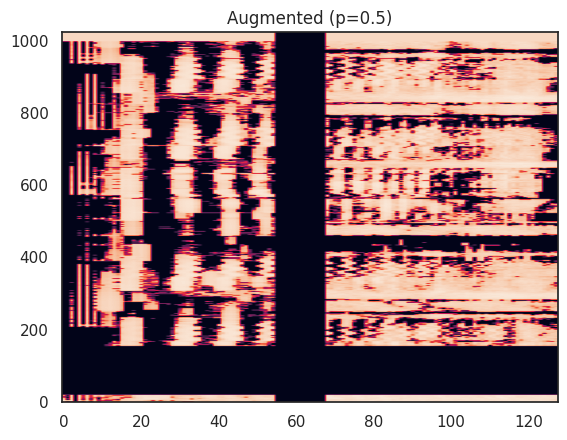

In [ ]:
import librosa
sns.set(style="white")

spec = train_dataset[0][0]
def plot_spec(ax, spec, title):
    ax.set_title(title)
    ax.imshow(librosa.power_to_db(spec), origin="lower", aspect="auto")

fig, axes = plt.subplots()
plot_spec(axes, spec[0], title="Augmented (p=0.5)")

In [ ]:
from torch.utils.data import WeightedRandomSampler

batch_size = 64

train_counter = Counter(train_dataset._labels)
weights = [1/train_counter.get(l) for l in train_dataset._labels]
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)


def collate_fn(batch):
    waveforms = []
    labels = []
    ids = []
    for waveform, label, ytid in batch:
        waveforms.append(waveform)
        labels.append(label)
        ids.append(ytid)
    waveforms = torch.stack(waveforms).squeeze(1)
    labels = torch.tensor(labels, dtype=torch.long)
    return waveforms, labels, ids


train_loader = torch_data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    collate_fn=collate_fn,
    num_workers=4
)

val_loader = torch_data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4
)

test_loader = torch_data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
len(train_loader)

328

## Preparing the model

In [ ]:
model = ASTForAudioClassification.from_pretrained(checkpoint).to(device)
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [ ]:
model.classifier.dense = nn.Linear(model.config.hidden_size, 30)
model.to(device)

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.audio_spectrogram_transformer.encoder.layer[-3:].parameters():
    param.requires_grad = True

for param in model.audio_spectrogram_transformer.layernorm.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

audio_spectrogram_transformer.embeddings.cls_token: requires_grad=False
audio_spectrogram_transformer.embeddings.distillation_token: requires_grad=False
audio_spectrogram_transformer.embeddings.position_embeddings: requires_grad=False
audio_spectrogram_transformer.embeddings.patch_embeddings.projection.weight: requires_grad=False
audio_spectrogram_transformer.embeddings.patch_embeddings.projection.bias: requires_grad=False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.query.weight: requires_grad=False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.query.bias: requires_grad=False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.key.weight: requires_grad=False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.key.bias: requires_grad=False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.value.weight: requires_grad=False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.value.bias: req

## Training

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from tqdm import tqdm as tq



def train_epoch(model, optimizer, criterion, loader):
    model.train()
    cum_loss = 0
    all_preds = []
    all_labels = []

    for features, labels, _ in tq(loader, desc="Training"):
        features, labels = {'input_values': features.to(device)}, labels.to(device)

        optimizer.zero_grad()
        outputs = model(**features)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    bacc = balanced_accuracy_score(all_labels, all_preds)
    return cum_loss / len(loader), bacc


def evaluate(model, criterion, loader):
    model.eval()
    cum_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels, _ in tq(loader, desc="Evaluating"):
            features, labels = {'input_values': features.to(device)}, labels.to(device)

            outputs = model(**features)
            logits = outputs.logits
            loss = criterion(logits, labels)

            cum_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    bacc = balanced_accuracy_score(all_labels, all_preds)
    return cum_loss / len(loader), bacc

In [ ]:
num_epochs = 10
learning_rate = 1e-5

def lr_lambda(epoch):
    if epoch < 5:
        return 1.0
    else:
        return 0.85

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=1e-4)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=True)
criterion = nn.CrossEntropyLoss()

In [ ]:
# my_checkpoint = torch.load("/kaggle/input/astfinetunedepoch3/pytorch/default/1/AST-finetuned_epoch3_BAcc0.6381.pth")
# model.load_state_dict(my_checkpoint["model_state_dict"])
# optimizer.load_state_dict(my_checkpoint["optimizer_state_dict"])
# scheduler.load_state_dict(my_checkpoint["scheduler_state_dict"])
# train_loss_history = my_checkpoint["train_loss_history"]
# val_loss_history = my_checkpoint["val_loss_history"]
# train_baccuracy_history = my_checkpoint["train_baccuracy_history"]
# val_baccuracy_history = my_checkpoint["val_baccuracy_history"]
# len(train_loss_history)

In [ ]:
epochs_per_checkpoint = 1

train_loss_history = []
val_loss_history = []
train_baccuracy_history = []
val_baccuracy_history = []

for epoch in range(num_epochs):
    train_loss, train_baccuracy = train_epoch(model, optimizer, criterion, train_loader)
    val_loss, val_baccuracy = evaluate(model, criterion, val_loader)

    scheduler.step()

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_baccuracy_history.append(train_baccuracy)
    val_baccuracy_history.append(val_baccuracy)

    if (epoch + 1)%epochs_per_checkpoint == 0 or (epoch + 1) == num_epochs:
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss_history": train_loss_history,
            "val_loss_history": val_loss_history,
            "train_baccuracy_history": train_baccuracy_history,
            "val_baccuracy_history": val_baccuracy_history,
        }, f"AST-finetuned_epoch{epoch+1}_BAcc{val_baccuracy:.4f}.pth")

    print(f"EPOCH {epoch+1}\tTrain Loss: {train_loss:.4f}\tVal Loss: {val_loss:.4f}\tTrain BAcc: {train_baccuracy:.4f}\tVal BAcc: {val_baccuracy:.4f}")

Training:  23%|██▎       | 77/328 [11:25<37:06,  8.87s/it]

In [ ]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(1, 2, figsize=(17, 6))
ax[0].set(title="Loss function", xlabel="Epoch",)
ax[0].plot(np.arange(1, len(train_loss_history)+1), train_loss_history, label="Train")
ax[0].plot(np.arange(1, len(val_loss_history)+1), val_loss_history, label="Val")
ax[0].legend()
ax[1].set(title="Balanced Accuracy", xlabel="Epoch")
ax[1].plot(np.arange(1, len(train_baccuracy_history)+1), train_baccuracy_history, label="Train")
ax[1].plot(np.arange(1, len(val_baccuracy_history)+1), val_baccuracy_history, label="Val")
ax[1].legend()
None

## Inference

In [ ]:
model.eval()
result = []
for features, _, ytid in test_loader:
    features = {'input_values': features.to(device)}
    outputs = model(**features)
    logits = outputs.logits
    predict = torch.argmax(logits, dim=1).item()
    result.append((ytid[0], train_dataset._idx_to_label[predict]))

pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result_finetuned2.tsv', sep='\t', index=False)

# Third approach: extracting features from a pretrained AST and training a linear classifier + augmentation + weighted sampling

In [ ]:
import logging
import os

import numpy as np
import pandas as pd
import requests
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Uploading dataset

In [ ]:
DATADIR = 'ml_trains_data'
TRAINDIR = 'train'
TESTDIR = 'eval'

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O data.tar.gz "{download_url}"
!tar -xf data.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.appl

## Dataloaders for feature extraction

In [ ]:
from transformers import AutoFeatureExtractor, ASTModel

checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
train_size = 0.8

train_and_val_data = pd.read_csv(os.path.join(DATADIR, f'{TRAINDIR}.tsv'), sep='\t')
train_data = train_and_val_data[:int(len(train_and_val_data)*train_size)]
val_data = train_and_val_data[int(len(train_and_val_data)*train_size):]
test_data = pd.read_csv(os.path.join(DATADIR, f'{TESTDIR}.tsv'), sep='\t')

In [ ]:
import random

class Dataset(torch_data.Dataset):
    def __init__(self, data, read_labels=True, aug_prob=0.5):
        self.aug_prob = aug_prob
        self.freqm = 48
        self.timem = 192

        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}

        self._classes = len(labels) if read_labels else 0
        self._ytids = []
        self._pathes = []
        self._labels = []

        for _, row in data.iterrows():
            path = os.path.join(DATADIR, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)


    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err

        assert sample_rate == 16000
        assert waveform.shape[0] == 1

        melfeatures = feature_extractor(
            waveform.squeeze(1).numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            truncation=True
        )['input_values']

        if random.random() < self.aug_prob:
            freqm = torchaudio.transforms.FrequencyMasking(self.freqm)
            timem = torchaudio.transforms.TimeMasking(self.timem)
            melfeatures = torch.transpose(melfeatures, 1, 2)
            melfeatures = freqm(melfeatures)
            melfeatures = timem(melfeatures)
            melfeatures = torch.transpose(melfeatures, 1, 2)

        return (melfeatures, self._labels[index], self._ytids[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes



train_dataset1 = Dataset(train_data, True, 1.0)
train_dataset2 = Dataset(train_data, True, 1.0)
val_dataset = Dataset(val_data, True, 0.0)
test_dataset = Dataset(test_data, False, 0.0)

In [ ]:
batch_size=64

def collate_fn(batch):
    waveforms = []
    labels = []
    ids = []
    for waveform, label, ytid in batch:
        waveforms.append(waveform)
        labels.append(label)
        ids.append(ytid)
    waveforms = torch.stack(waveforms).squeeze(1)
    labels = torch.tensor(labels, dtype=torch.long)
    return waveforms, labels, ids


train_loader1 = torch_data.DataLoader(
    train_dataset1,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

train_loader2 = torch_data.DataLoader(
    train_dataset2,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = torch_data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

test_loader = torch_data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

## Audio Spectrogram Transformer for feature extraction

In [ ]:
model = ASTModel.from_pretrained(checkpoint).to(device)
model

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ASTModel(
  (embeddings): ASTEmbeddings(
    (patch_embeddings): ASTPatchEmbeddings(
      (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ASTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ASTLayer(
        (attention): ASTSdpaAttention(
          (attention): ASTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ASTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ASTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [ ]:
def get_features(loader):
    features_list = []
    labels_list = []
    ids_list = []
    for features, labels, ids in tqdm(loader):
        with torch.no_grad():
            features = {'input_values': features.to(device)}
            outputs = model(**features)
            embeddings = outputs.last_hidden_state[:, 0, :] # (batch_size, seq_len, emb_dim) -> (batch_size, emb_dim)

        for emb_idx in range(embeddings.size(0)):
            features_list.append(embeddings[emb_idx, :].cpu())
            labels_list.append(labels[emb_idx])
            ids_list.append(ids[emb_idx])

    return features_list, labels_list, ids_list

In [ ]:
train_features1, train_labels1, train_ids1 = get_features(train_loader1)
train_features2, train_labels2, train_ids2 = get_features(train_loader2)
val_features, val_labels, val_ids = get_features(val_loader)
test_features, test_labels, test_ids = get_features(test_loader)

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
torch.save({
    "features": train_features1,
    "labels": train_labels1,
    "ids": train_ids1
    }, "train_features1.pt")

torch.save({
    "features": train_features2,
    "labels": train_labels2,
    "ids": train_ids2
    }, "train_features2.pt")

torch.save({
    "features": val_features,
    "labels": val_labels,
    "ids": val_ids
    }, "val_features.pt")

torch.save({
    "features": test_features,
    "labels": test_labels,
    "ids": test_ids
    }, "test_features.pt")

In [ ]:
train_data1 = torch.load("train_features1.pt")
train_features1 = train_data["features"]
train_labels1 = train_data["labels"]
train_ids1 = train_data["ids"]

train_data2 = torch.load("train_features2.pt")
train_features2 = train_data["features"]
train_labels2 = train_data["labels"]
train_ids2 = train_data["ids"]

val_data = torch.load("val_features.pt")
val_features = val_data["features"]
val_labels = val_data["labels"]
val_ids = val_data["ids"]

test_data = torch.load("test_features.pt")
test_features = test_data["features"]
test_labels = test_data["labels"]
test_ids = test_data["ids"]

## Dataloaders for classifier

In [ ]:
class ClassDataset(torch_data.Dataset):
    def __init__(self, features1, ytids1=None, labels1=None, features2=None, ytids2=None, labels2=None):
        super().__init__()
        self.features = features1
        if features2:
            self.features.extend(features2)

        self.ytids = ytids1
        if ytids2:
            self.ytids.extend(ytids2)

        self.labels = labels1
        if labels2:
            self.labels.extend(labels2)

    def __getitem__(self, index):
        if self.labels:
            return (self.features[index], self.labels[index])
        return (self.features[index], self.ytids[index])

    def __len__(self):
        return len(self.features)

train_dataset = ClassDataset(train_features1, None, train_labels1, train_features2, None, train_labels2)
val_dataset = ClassDataset(val_features, None, val_labels)
test_dataset = ClassDataset(test_features, test_ids, None)

In [ ]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

batch_size = 64

train_counter = Counter(train_dataset.labels)
weights = [1/train_counter.get(l) for l in train_dataset.labels]
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

train_loader = torch_data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = torch_data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch_data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## Training classifier

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score


class AudioClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, input):
        output = self.fc1(input)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output


def train_epoch(model, optimizer, criterion, loader):
    model.train()
    cum_loss = 0
    all_preds = []
    all_labels = []
    for feats, labels in loader:
        feats, labels = feats.to(device), labels.to(device)
        output = model(feats)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()

        preds = torch.argmax(output, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    bacc = balanced_accuracy_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    return cum_loss/len(loader), bacc, acc


def evaluate(model, criterion, loader):
    model.eval()
    cum_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for feats, labels in loader:
            feats, labels = feats.to(device), labels.to(device)
            output = model(feats)
            loss = criterion(output, labels)
            cum_loss += loss.item()

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    bacc = balanced_accuracy_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    return cum_loss/len(loader), bacc, acc

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


epochs = 50
learning_rate = 1e-4
input_dim = 768
output_dim = 30
hidden_dim = 512
dropout_rate = 0.7

classifier = AudioClassifier(input_dim, output_dim, hidden_dim, dropout_rate).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss_history = []
val_loss_history = []
train_baccuracy_history = []
val_baccuracy_history = []

for epoch in tqdm(range(epochs)):
    train_loss, train_baccuracy, _ = train_epoch(classifier, optimizer, criterion, train_loader)
    val_loss, val_baccuracy, val_acc = evaluate(classifier, criterion, val_loader)

    scheduler.step(val_loss)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_baccuracy_history.append(train_baccuracy)
    val_baccuracy_history.append(val_baccuracy)

    print(f"EPOCH {epoch+1} Train Loss:{train_loss:.4f} Val Loss: {val_loss:.4f} Train BAcc: {train_baccuracy:.4f} Val BAcc: {val_baccuracy:.4f} Val Acc: {val_acc:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 1 Train Loss:1.7399 Val Loss: 1.1973 Train BAcc: 0.5123 Val BAcc: 0.6322 Val Acc: 0.6327
EPOCH 2 Train Loss:1.2843 Val Loss: 1.1446 Train BAcc: 0.6094 Val BAcc: 0.6434 Val Acc: 0.6422
EPOCH 3 Train Loss:1.2078 Val Loss: 1.1202 Train BAcc: 0.6279 Val BAcc: 0.6471 Val Acc: 0.6477
EPOCH 4 Train Loss:1.1593 Val Loss: 1.1084 Train BAcc: 0.6391 Val BAcc: 0.6490 Val Acc: 0.6477
EPOCH 5 Train Loss:1.1040 Val Loss: 1.1009 Train BAcc: 0.6532 Val BAcc: 0.6491 Val Acc: 0.6485
EPOCH 6 Train Loss:1.0878 Val Loss: 1.0961 Train BAcc: 0.6585 Val BAcc: 0.6485 Val Acc: 0.6477
EPOCH 7 Train Loss:1.0683 Val Loss: 1.0906 Train BAcc: 0.6616 Val BAcc: 0.6492 Val Acc: 0.6471
EPOCH 8 Train Loss:1.0340 Val Loss: 1.0960 Train BAcc: 0.6668 Val BAcc: 0.6461 Val Acc: 0.6445
EPOCH 9 Train Loss:1.0306 Val Loss: 1.0935 Train BAcc: 0.6717 Val BAcc: 0.6437 Val Acc: 0.6445
EPOCH 10 Train Loss:0.9957 Val Loss: 1.0924 Train BAcc: 0.6753 Val BAcc: 0.6472 Val Acc: 0.6470
EPOCH 11 Train Loss:0.9852 Val Loss: 1.0932 Train

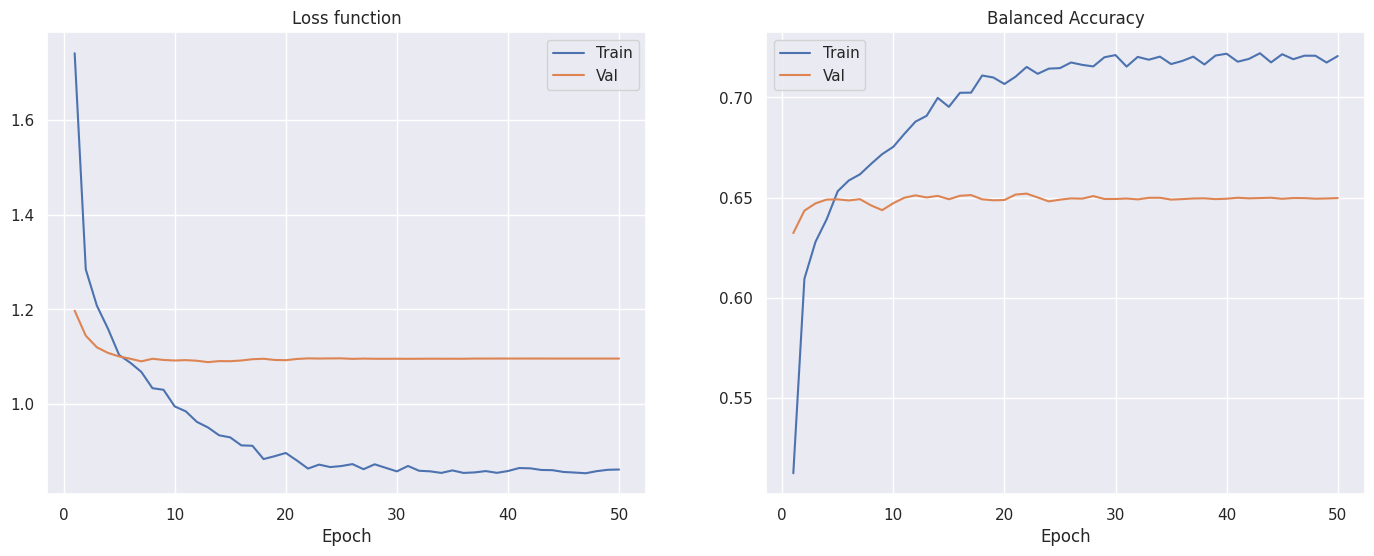

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline


fig, ax = plt.subplots(1, 2, figsize=(17, 6))
ax[0].set(title="Loss function", xlabel="Epoch",)
ax[0].plot(np.arange(1, len(train_loss_history)+1), train_loss_history, label="Train")
ax[0].plot(np.arange(1, len(val_loss_history)+1), val_loss_history, label="Val")
ax[0].legend()
ax[1].set(title="Balanced Accuracy", xlabel="Epoch")
ax[1].plot(np.arange(1, len(train_baccuracy_history)+1), train_baccuracy_history, label="Train")
ax[1].plot(np.arange(1, len(val_baccuracy_history)+1), val_baccuracy_history, label="Val")
ax[1].legend()
None

In [ ]:
classifier.eval()
result = []
for features, id in test_loader:
    predict = torch.argmax(classifier.forward(features.to(device)), dim=1).item()
    result.append((id[0], train_dataset1._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result123.tsv', sep='\t', index=False)